In [1]:
pip freeze

absl-py==0.15.0
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client==1.7.2
anaconda-navigator==2.0.3
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1610472525955/work
anyio @ file:///C:/ci/anyio_1620153418380/work/dist
appdirs==1.4.4
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1613037959010/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///C:/ci/astroid_1613501047216/work
astropy @ file:///C:/ci/astropy_1617745647203/work
astunparse==1.6.3
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1615918855173/work
Babel @ file:///tmp/build/80754af9/babel_1607110387436/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backports.functools-lru-cache @ file:///tmp/build/80754af9/backports.functools_lru_cache_1618170165463/w

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16377272340357721859
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6934495232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11215179667087098437
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
!nvidia-smi

Mon Dec  6 02:43:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.89       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   49C    P2    47W / 200W |   1509MiB /  8192MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model

In [23]:
model_name = Xception
name = 'Xception'
batch_size = 16
train_epoch = 300
val_epoch = 50
seed = 42
image_size = 224
LP = 99
lr = 0.0001
decay = 0.001

In [24]:
# train data generator object
train_aug = ImageDataGenerator(
    rescale = 1./255
  )

# validation data generator object
valid_aug = ImageDataGenerator(
    rescale = 1./255
  )

# 학습 데이터

In [25]:
n_class = 5
train_root_path = "C:\\knee_data\\train"
train_image_path_list = []
train_label_list = []

for label in range(n_class):
    train_image_list = os.listdir(f"{train_root_path}/{label}")
    train_image_path_list += [ f"{train_root_path}/{label}/"+ path for path in train_image_list]
    train_label_list += [label] * len(train_image_list)

df_train = pd.DataFrame({"filepath" : train_image_path_list, "label": train_label_list})
df_train

,filepath,label
0,C:\knee_data\train/0/9001695L.png,0
1,C:\knee_data\train/0/9001897L.png,0
2,C:\knee_data\train/0/9003126L.png,0
3,C:\knee_data\train/0/9003126R.png,0
4,C:\knee_data\train/0/9003175L.png,0
...,...,...
17609,C:\knee_data\train/4/Image_849.jpg,4
17610,C:\knee_data\train/4/Image_907.jpg,4
17611,C:\knee_data\train/4/Image_910.jpg,4
17612,C:\knee_data\train/4/Image_948.jpg,4


In [26]:
df_train.shape

(17614, 2)

Text(0, 0.5, 'count')

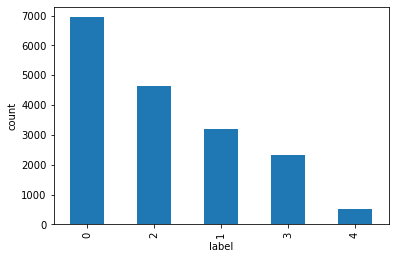

In [27]:
df_train.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [28]:
# create train generator
train_generator = train_aug.flow_from_dataframe(
    dataframe = df_train,
    directory = None,
    x_col = "filepath",
    y_col = "label",
    batch_size = batch_size,
    seed = seed,
    shuffle = True,
    class_mode = "raw",
    target_size = (image_size,image_size)
  )

Found 17614 validated image filenames.


# 검증 데이터

In [29]:
n_class = 5
validation_root_path = "C:\\knee_data\\validataion"
validation_image_path_list = []
validation_label_list = []

for label in range(n_class):
    validation_image_list = os.listdir(f"{validation_root_path}/{label}")
    validation_image_path_list += [ f"{validation_root_path}/{label}/"+ path for path in validation_image_list]
    validation_label_list += [label] * len(validation_image_list)

df_validation = pd.DataFrame({"filepath" : validation_image_path_list, "label": validation_label_list})
df_validation

,filepath,label
0,C:\knee_data\validataion/0/5a21060fe4b0f1e9e56...,0
1,C:\knee_data\validataion/0/5a21060fe4b0f1e9e56...,0
2,C:\knee_data\validataion/0/5a21112ee4b09b69e60...,0
3,C:\knee_data\validataion/0/5a21112ee4b09b69e60...,0
4,C:\knee_data\validataion/0/5a28d27ae4b028f6846...,0
...,...,...
518,C:\knee_data\validataion/4/5b0e3cede4b07f99d60...,4
519,C:\knee_data\validataion/4/5b0f64cde4b0b80049b...,4
520,C:\knee_data\validataion/4/5b10dab8e4b07f99d61...,4
521,C:\knee_data\validataion/4/5b10dab8e4b07f99d61...,4


In [30]:
df_validation.shape

(523, 2)

Text(0, 0.5, 'count')

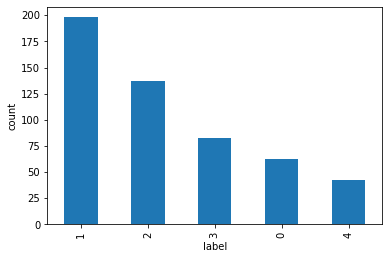

In [31]:
df_validation.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [32]:
# create validation generator
valid_generator = valid_aug.flow_from_dataframe( 
    dataframe = df_validation,
    x_col = "filepath",
    y_col = "label",
    batch_size = batch_size,
    seed = seed,
    shuffle= True,
    class_mode = "raw",
    target_size = (image_size,image_size)
  )

Found 523 validated image filenames.


# 모델

In [33]:
sel_model = model_name(weights = "imagenet",)
x = sel_model.layers[-10].output

x = tf.keras.layers.Conv2D(filters = 1024, kernel_size = 3, padding = "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, padding = "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters = n_class, kernel_size = 3, padding = "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

pic_model = Model(inputs=sel_model.input,outputs = pred)
# pic_model = multi_gpu_model(pic_model, gpus=2)

In [34]:
pic_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [35]:
# compile
pic_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr, decay = decay),
    metrics = ["acc"],
    loss = tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_name = name+"_BS"+str(batch_size)+"_EP"+str(train_epoch)+"_IS"+str(image_size)+"_LP"+str(LP)
checkpoint_path = checkpoint_name+".ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

my_callbacks = [
              ModelCheckpoint(
                   checkpoint_path,
                   monitor = 'val_acc',
                   verbose = 1,
                   save_weights_only = True,
                   save_best_only = True,
                   mode = "max"
                  ),
#               EarlyStopping(
#                    monitor = 'val_loss',
#                    patience = 10,
#                    verbose = 0
#                   ),
              ReduceLROnPlateau(
                   monitor = 'val_loss',
                   patience = 10,
                   verbose = 1
                  )
]

# Weighting classes


In [36]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes = np.unique(df_train.label.values),
    y = df_train.label.values
  )

class_weights = dict(enumerate(class_weights))

In [37]:
count0, count1, count2, count3, count4 = 0, 0, 0, 0, 0

for i in range(len(df_train.label.values)):
    if df_train.label.values[i] == 0:
        count0 +=1
    elif df_train.label.values[i] == 1:
        count1 +=1
    elif df_train.label.values[i] == 2:
        count2 +=1
    elif df_train.label.values[i] == 3:
        count3 +=1
    elif df_train.label.values[i] == 4:
        count4 +=1
        
print("Grade 0, number of samples :", count0, ", number of weights : ", class_weights[0])
print("Grade 1, number of samples :", count1, ", number of weights : ", class_weights[1])
print("Grade 2, number of samples :", count2, ", number of weights : ", class_weights[2])
print("Grade 3, number of samples :", count3, ", number of weights : ", class_weights[3])
print("Grade 4, number of samples :", count4, ", number of weights : ", class_weights[4])

Grade 0, number of samples : 6942 , number of weights :  0.5074618265629501
Grade 1, number of samples : 3186 , number of weights :  1.10571249215317
Grade 2, number of samples : 4640 , number of weights :  0.7592241379310345
Grade 3, number of samples : 2315 , number of weights :  1.5217278617710583
Grade 4, number of samples : 531 , number of weights :  6.634274952919021


# Train

In [38]:
# train the model
pic_model.fit(
        train_generator,
        epochs = train_epoch,
        validation_data = valid_generator,
        callbacks = [my_callbacks],
        class_weight = class_weights
      )

# load best saved weights
pic_model.load_weights(checkpoint_path)

Epoch 1/300
1101/1101 [==============================] - 356s 319ms/step - loss: 1.0789 - acc: 0.5496 - val_loss: 1.4046 - val_acc: 0.4436

Epoch 00001: val_acc improved from -inf to 0.44359, saving model to Xception_BS16_EP300_IS224_LP99.ckpt
Epoch 2/300
1101/1101 [==============================] - 341s 310ms/step - loss: 0.8148 - acc: 0.7100 - val_loss: 1.4571 - val_acc: 0.4073

Epoch 00002: val_acc did not improve from 0.44359
Epoch 3/300
1101/1101 [==============================] - 364s 330ms/step - loss: 0.6237 - acc: 0.8401 - val_loss: 1.5162 - val_acc: 0.4130

Epoch 00003: val_acc did not improve from 0.44359
Epoch 4/300
1101/1101 [==============================] - 337s 306ms/step - loss: 0.5120 - acc: 0.9150 - val_loss: 1.5642 - val_acc: 0.3901

Epoch 00004: val_acc did not improve from 0.44359
Epoch 5/300
1101/1101 [==============================] - 324s 294ms/step - loss: 0.4601 - acc: 0.9513 - val_loss: 1.6000 - val_acc: 0.3537

Epoch 00005: val_acc did not improve from 0.44

KeyboardInterrupt: 

In [71]:
# kick off training
pic_model.fit(
        train_generator,
        steps_per_epoch = STEP_SIZE_TRAIN,
        epochs = val_epoch,
        validation_data = valid_generator,
        validation_steps = STEP_SIZE_VALID,callbacks = [my_callbacks]
      )

Epoch 1/50
880/880 [==============================] - 80s 89ms/step - loss: 0.6163 - acc: 0.9751 - val_loss: 0.4056 - val_acc: 0.9936

Epoch 00001: val_acc did not improve from 0.99591
Epoch 2/50
880/880 [==============================] - 77s 88ms/step - loss: 0.6001 - acc: 0.9855 - val_loss: 0.3948 - val_acc: 1.0000

Epoch 00002: val_acc improved from 0.99591 to 1.00000, saving model to Xception_BS8_EP300_IS224_LP99.ckpt
Epoch 3/50
880/880 [==============================] - 78s 88ms/step - loss: 0.6028 - acc: 0.9888 - val_loss: 0.4072 - val_acc: 0.9974

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/50
880/880 [==============================] - 77s 88ms/step - loss: 0.5950 - acc: 0.9909 - val_loss: 0.4086 - val_acc: 0.9987

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/50
880/880 [==============================] - 78s 88ms/step - loss: 0.6012 - acc: 0.9895 - val_loss: 0.4061 - val_acc: 0.9974

Epoch 00005: val_acc did not improve from 1.00000
Epoch 6/50
880/880 

# Confusion Matrix

In [73]:
from sklearn.metrics import precision_recall_curve
target_shape = 224
BS = 1

# test generator
compi_gen = valid_aug.flow_from_dataframe(
    dataframe = X_test,
    x_col = "filename",
    class_mode = None,
    target_size = (target_shape, target_shape),
    shuffle = False,
    batch_size = BS
  )

Found 783 validated image filenames.


In [128]:
# train and validation split on competition data
from sklearn.model_selection import train_test_split

test_da = train_test_split(
    df_test,
    test_size = 0.1,
    random_state = seed,
    stratify = df_test.label
  )

In [74]:
# prediction on train data
predicition_compi = pic_model.predict(compi_gen, steps = compi_gen.n/ BS, verbose= 1)

783/783 [==============================] - 6s 7ms/step


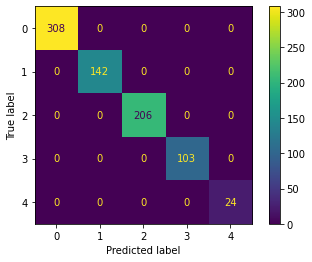

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_prediction_compi = np.argmax(predicition_compi, axis = 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels = [0, 1, 2, 3, 4])

disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = [0, 1, 2, 3, 4]
  )

disp.plot()

# 시험세트 예측

In [164]:
# read the csv file
test_path = "C:\\Users\\dodo9\\Downloads\\aug_knee_data\\"
test = pd.read_csv(test_path + "Test.csv")

test_aug = ImageDataGenerator(
    rescale = 1./255
    )

# create test generator
test_generator = test_aug.flow_from_dataframe(
    dataframe = test,
    directory = test_path + "test",
    x_col = "filename",
    y_col = None,
    batch_size = 1,
    seed = seed,
    shuffle = False,
    class_mode = None,
    target_size = (image_size, image_size)
    )

# number of steps to consider 1 epoch
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

Found 0 validated image filenames.


C:\Users\ngkim\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1958 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [78]:
# make prediction and create dataframe out of it
pred = pic_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
df_submit = pd.DataFrame({"label":np.argmax(pred, axis= 1)})
df_submit["label"].value_counts()

1958/1958 [==============================] - 15s 8ms/step


0    776
2    516
1    350
3    257
4     59
Name: label, dtype: int64

# 최적의 가중치 및 출력 예측 파일 저장

In [79]:
pic_model.save_weights(name+"_BS"+str(batch_size)+"_EP"+str(train_epoch)+"_IS"+str(image_size)+"_LP"+str(LP)+".h5")

In [81]:
df_submit.to_csv(name+"_BS"+str(batch_size)+"_EP"+str(train_epoch)+"_IS"+str(image_size)+"_LP"+str(LP)+".csv",index = False)